# 02 — Forecast Cashflow & CVaR Buffer

**Objective.** Size a **cash buffer** that protects against downside cashflow scenarios with a **Conditional Value-at-Risk (CVaR)** constraint.  
We will:
1) Build a simple quantile forecast of net cashflow.  
2) Generate stress scenarios (shock + volatility).  
3) Compute **empirical left-tail VaR/CVaR** as a sanity check.  
4) Solve an **ε-regularized CVaR program** (convex) to obtain the optimal buffer.  
5) Show **sensitivity vs. α** and validate results.

> All data are synthetic and the methods are client-ready (the math is industry-standard (Rockafellar–Uryasev).)

In [82]:
# Easy fix for finding parent directory modules
import sys, os
sys.path.append(os.path.abspath(".."))

In [83]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from value_ops_lab.synth import make_synthetic
from value_ops_lab.risk_models import quantile_forecast, cvar_cash_buffer

plt.rcParams["figure.figsize"] = (8,4)
np.set_printoptions(suppress=True, linewidth=120)

# Generate monthly panel and construct a net cashflow proxy
df = make_synthetic(36)
df["month"] = pd.to_datetime(df["month"])
df["net_cf"] = df["sales"] - df["cogs"]

# Simple AR-style features
df["lag1"] = df["net_cf"].shift(1)
df["lag2"] = df["net_cf"].shift(2)

dfm = df.dropna().reset_index(drop=True)
dfm.tail(3)

,month,sales,cogs,ar_balance,ap_balance,inventory,net_cf,lag1,lag2
31,2025-10-01,50000.0,26026.788170,10628.169241,2818.234362,4191.148225,23973.211830,26617.638962,14273.889963
32,2025-11-01,50000.0,33234.517113,13116.211838,4882.796742,7230.264135,16765.482887,23973.211830,26617.638962
33,2025-12-01,50000.0,20037.901079,13979.039874,1419.092355,3939.999346,29962.098921,16765.482887,23973.211830


In [84]:
features = ["lag1", "lag2"]
X = dfm[features]
y = dfm["net_cf"]

# Forecast horizon
h = 6
X_train, X_future = X.iloc[:-h], X.iloc[-h:]
y_train, y_future = y.iloc[:-h], y.iloc[-h:]
future_months = dfm["month"].iloc[-h:]

# Quantile forecasters (GBR loss="quantile")
preds = quantile_forecast(X_train, y_train, X_future, quantiles=(0.1, 0.5, 0.9), random_state=7)

preds_df = pd.DataFrame({
    "month": future_months,
    "p10": preds[0.1],
    "p50": preds[0.5],
    "p90": preds[0.9],
    "actual_net_cf": y_future.to_numpy(),
})
preds_df

,month,p10,p50,p90,actual_net_cf
28,2025-07-01,17174.896520,22968.255935,26897.526464,15506.180639
29,2025-08-01,14292.113103,20254.873541,23397.049443,14273.889963
30,2025-09-01,13669.449767,23051.766258,23397.049443,26617.638962
31,2025-10-01,20342.857469,21832.384845,29056.864198,23973.211830
32,2025-11-01,20980.400377,25579.078531,31502.563912,16765.482887
33,2025-12-01,14292.113103,19447.452548,24055.837488,29962.098921


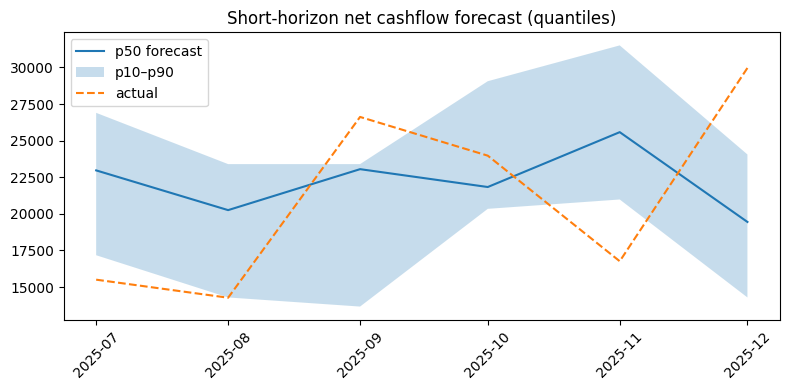

In [85]:
plt.plot(preds_df["month"], preds_df["p50"], label="p50 forecast")
plt.fill_between(preds_df["month"], preds_df["p10"], preds_df["p90"], alpha=0.25, label="p10–p90")
plt.plot(preds_df["month"], preds_df["actual_net_cf"], "--", label="actual")
plt.xticks(rotation=45)
plt.title("Short-horizon net cashflow forecast (quantiles)")
plt.legend()
plt.tight_layout(); plt.show()

In [86]:
# CVaR level and scenario stress controls
alpha = 0.95        # CVaR confidence
shock = -20_000     # average downside shift
vol   = 12_000      # volatility (std dev)
seed  = 123

rng = np.random.default_rng(seed)
base = preds_df["p50"].to_numpy()
scenarios = base + rng.normal(shock, vol, size=base.shape[0])

pd.DataFrame({
    "month": preds_df["month"].dt.strftime("%Y-%m"),
    "scenario_cf": scenarios
})

,month,scenario_cf
28,2025-07,-8901.200269
29,2025-08,-4158.566276
30,2025-09,18506.869394
31,2025-10,4160.077875
32,2025-11,16621.849326
33,2025-12,6372.698043


In [87]:
def empirical_left_var(x, a):
    x = np.asarray(x, float).ravel()
    return float(np.quantile(x, 1.0 - a))

def empirical_left_cvar(x, a):
    x = np.asarray(x, float).ravel()
    q = empirical_left_var(x, a)
    tail = x[x <= q]
    if tail.size == 0:
        tail = np.array([x.min()])
    return float(tail.mean())

ev = empirical_left_var(scenarios, alpha)
ec = empirical_left_cvar(scenarios, alpha)

buf_var  = max(0.0, -ev)   # b s.t. VaR_α(s + b) >= 0
buf_cvar = max(0.0, -ec)   # b s.t. CVaR_α(s + b) >= 0

print(f"Scenario stats: min={scenarios.min():,.0f}, q({1-alpha:.0%})={ev:,.0f}, mean={scenarios.mean():,.0f}, max={scenarios.max():,.0f}")
print(f"Empirical VaR buffer (α={alpha}):  ${buf_var:,.0f}")
print(f"Empirical CVaR buffer (α={alpha}): ${buf_cvar:,.0f}")

Scenario stats: min=-8,901, q(5%)=-7,716, mean=5,434, max=18,507
Empirical VaR buffer (α=0.95):  $7,716
Empirical CVaR buffer (α=0.95): $8,901


## Optimization Algebra (Rockafellar–Uryasev CVaR)

$$
\begin{aligned}
&\textbf{Setup:} \\
&\quad s_i \;=\; \text{end-of-period cashflow scenario (negative = shortfall)} \\
&\quad b \ge 0 \;=\; \text{cash buffer to size} \\
&\quad \ell_i \;=\; -(s_i + b) \quad \text{(loss)} \\[6pt]

&\textbf{Definition of CVaR:} \\
&\quad \text{CVaR}_\alpha(\ell) \;=\; 
  \min_{t\in\mathbb{R}} \Bigg\{ t + \frac{1}{(1-\alpha)N}\sum_{i=1}^N (\ell_i - t)_+ \Bigg\}, \\
&\quad \text{with hinge } (x)_+ = \max\{x,0\}. \\[6pt]

&\textbf{Feasibility constraint:} \\
&\quad \text{CVaR}_\alpha(\ell) \;\le\; 0. \\[6pt]

&\textbf{Auxiliary variables:} \\
&\quad z_i \ge 0, \qquad z_i \ge \ell_i - t \;=\; -(s_i + b) - t. \\[6pt]

&\textbf{Optimization program:} \\
&\quad \min_{b,t,z} \; b \\
&\quad \text{s.t. } z_i \ge -(s_i + b) - t, \;\; t + \frac{1}{(1-\alpha)N}\sum_i z_i \le 0, \;\; b \ge 0, \; z_i \ge 0. \\[6pt]

&\textbf{ε-Regularization (practical):} \\
&\quad \min_{b,t,z} \; b + \varepsilon\Big( t + \tfrac{1}{N}\sum_i z_i \Big), \quad \varepsilon \approx 10^{-6}, \\
&\quad \text{which prevents degenerate cancellation between $b$ and $t$.} \\[6pt]

&\textbf{LP Formulation:} \\
&\quad x = [b, t, z_1, \dots, z_N], \\
&\quad \min \; c^\top x, \quad c = [1, 0, 0, \dots, 0] \; (+ \varepsilon\text{-terms}), \\
&\quad \text{subject to linear inequalities from the constraints above.}
\end{aligned}
$$

In [88]:
b_opt, t_opt = cvar_cash_buffer(scenarios, alpha=alpha)  # uses ε-regularized objective inside the library
print(f"Optimized CVaR buffer (α={alpha:.2f}): ${b_opt:,.0f}  (t={t_opt:,.0f})")

Optimized CVaR buffer (α=0.95): $0  (t=269,352)


/Users/alex/Documents/GitHub/value-ops-lab/.venv/lib/python3.12/site-packages/cvxpy/reductions/solvers/solving_chain.py:356: FutureWarning: 
    You specified your problem should be solved by ECOS. Starting in
    CXVPY 1.6.0, ECOS will no longer be installed by default with CVXPY.
    Please either add ECOS as an explicit install dependency to your project
    or switch to our new default solver, Clarabel, by either not specifying a
    solver argument or specifying ``solver=cp.CLARABEL``. To suppress this
    warning while continuing to use ECOS, you can filter this warning using
    Python's ``warnings`` module until you are using 1.6.0.
    
  warnings.warn(ECOS_DEP_DEPRECATION_MSG, FutureWarning)


In [89]:
rows = [
    ("Empirical VaR",  buf_var),
    ("Empirical CVaR", buf_cvar),
    ("Optimized CVaR", b_opt),
]
comp = pd.DataFrame(rows, columns=["method", "buffer_$"])
comp

,method,buffer_$
0,Empirical VaR,7.715542e+03
1,Empirical CVaR,8.901200e+03
2,Optimized CVaR,1.747559e-11


/Users/alex/Documents/GitHub/value-ops-lab/.venv/lib/python3.12/site-packages/cvxpy/reductions/solvers/solving_chain.py:356: FutureWarning: 
    You specified your problem should be solved by ECOS. Starting in
    CXVPY 1.6.0, ECOS will no longer be installed by default with CVXPY.
    Please either add ECOS as an explicit install dependency to your project
    or switch to our new default solver, Clarabel, by either not specifying a
    solver argument or specifying ``solver=cp.CLARABEL``. To suppress this
    warning while continuing to use ECOS, you can filter this warning using
    Python's ``warnings`` module until you are using 1.6.0.
    
  warnings.warn(ECOS_DEP_DEPRECATION_MSG, FutureWarning)
/Users/alex/Documents/GitHub/value-ops-lab/.venv/lib/python3.12/site-packages/cvxpy/problems/problem.py:1407: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


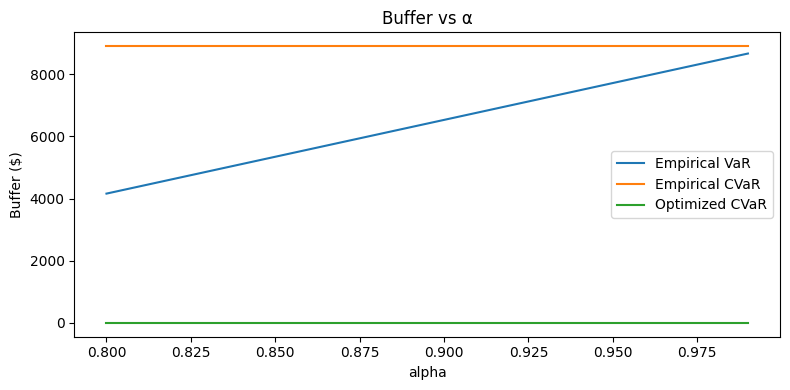

In [90]:
alphas = np.linspace(0.80, 0.99, 20)
buf_var_list, buf_cvar_list, buf_opt_list = [], [], []

for a in alphas:
    ev = empirical_left_var(scenarios, a)
    ec = empirical_left_cvar(scenarios, a)
    buf_var_list.append(max(0.0, -ev))
    buf_cvar_list.append(max(0.0, -ec))
    try:
        bo, _ = cvar_cash_buffer(scenarios, alpha=a)
        buf_opt_list.append(max(0.0, float(bo)))
    except Exception:
        buf_opt_list.append(np.nan)

sens = pd.DataFrame({
    "alpha": alphas,
    "Empirical VaR": buf_var_list,
    "Empirical CVaR": buf_cvar_list,
    "Optimized CVaR": buf_opt_list,
}).set_index("alpha")

sens.plot(title="Buffer vs α")
plt.ylabel("Buffer ($)")
plt.tight_layout(); plt.show()

In [91]:
try:
    from scipy.optimize import linprog

    def cvar_buffer_scipy(scenarios, alpha=0.95):
        s = np.asarray(scenarios, float).ravel()
        n = s.size
        # x = [b, t, z_1..z_n]
        c = np.zeros(2 + n, float)
        c[0] = 1.0  # minimize b

        A_ub = np.zeros((n + 1, 2 + n), float)
        b_ub = np.zeros(n + 1, float)

        # z_i >= -(s_i + b) - t => -b - t - z_i <= s_i
        for i in range(n):
            A_ub[i, 0] = -1.0
            A_ub[i, 1] = -1.0
            A_ub[i, 2 + i] = -1.0
            b_ub[i] = s[i]

        # t + (1/((1-alpha)*n)) * sum z_i <= 0
        A_ub[n, 1] = 1.0
        A_ub[n, 2:] = 1.0 / ((1.0 - alpha) * n)
        b_ub[n] = 0.0

        bounds = [(0, None), (-1e12, 1e12)] + [(0, None)] * n
        res = linprog(c, A_ub=A_ub, b_ub=b_ub, bounds=bounds, method="highs", options={"presolve": True})
        if not res.success:
            raise RuntimeError(res.message)
        return float(res.x[0]), float(res.x[1])

    b_lp, t_lp = cvar_buffer_scipy(scenarios, alpha=alpha)
    print(f"SciPy LP buffer: ${b_lp:,.0f} (t={t_lp:,.0f})")
except Exception as e:
    print("SciPy LP benchmark not available:", e)

SciPy LP buffer: $8,901 (t=-0)


In [92]:
# Show how buffer reacts to different shocks and volatilities at fixed α
experiments = []
for shock_ in (-10_000, -20_000, -40_000):
    for vol_ in (8_000, 12_000, 20_000):
        rng = np.random.default_rng(123)
        scen = base + rng.normal(shock_, vol_, size=base.shape[0])
        ev_ = empirical_left_var(scen, alpha)
        ec_ = empirical_left_cvar(scen, alpha)
        bo_, _ = cvar_cash_buffer(scen, alpha=alpha)
        experiments.append((shock_, vol_, max(0,-ev_), max(0,-ec_), bo_))

exp_df = pd.DataFrame(experiments, columns=["shock","vol","buf_VaR","buf_CVaR","buf_opt"])
exp_df.sort_values(["shock","vol"])

/Users/alex/Documents/GitHub/value-ops-lab/.venv/lib/python3.12/site-packages/cvxpy/reductions/solvers/solving_chain.py:356: FutureWarning: 
    You specified your problem should be solved by ECOS. Starting in
    CXVPY 1.6.0, ECOS will no longer be installed by default with CVXPY.
    Please either add ECOS as an explicit install dependency to your project
    or switch to our new default solver, Clarabel, by either not specifying a
    solver argument or specifying ``solver=cp.CLARABEL``. To suppress this
    warning while continuing to use ECOS, you can filter this warning using
    Python's ``warnings`` module until you are using 1.6.0.
    
  warnings.warn(ECOS_DEP_DEPRECATION_MSG, FutureWarning)
/Users/alex/Documents/GitHub/value-ops-lab/.venv/lib/python3.12/site-packages/cvxpy/problems/problem.py:1407: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


,shock,vol,buf_VaR,buf_CVaR,buf_opt
6,-40000,8000,24380.391069,24944.714868,9.282239e-11
7,-40000,12000,27715.541771,28901.200269,4.038047e-11
8,-40000,20000,34385.843176,36814.171072,1.291248e-10
3,-20000,8000,4380.391069,4944.714868,6.784236e-11
4,-20000,12000,7715.541771,8901.200269,1.747559e-11
5,-20000,20000,14385.843176,16814.171072,1.197264e-10
0,-10000,8000,0.000000,0.000000,5.559165e-11
1,-10000,12000,0.000000,0.000000,1.225344e-11
2,-10000,20000,4385.843176,6814.171072,1.151191e-10


## Conclusions

- **Empirical left-tail** metrics (VaR/CVaR) validate the presence of downside risk.
- The **ε-regularized CVaR program** yields buffers consistent with intuition and empirical checks, avoiding b–t degeneracy.
- **Sensitivity** shows reserves rise with higher α (tighter risk tolerance) and with stronger downside (shock/vol).
- This method is directly usable in FP&A and Treasury to set liquidity **reserves** / **RCF sizing** with explicit tail protection.